### Base imports

In [1]:
import os
import zipfile
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np


### Unzip dataset files

In [2]:
# !pip install --upgrade gdown
!gdown --folder https://drive.google.com/drive/folders/1zS9fQdj2-sKsYZ6DqZWljZKy2cErg8zz -O datasets/road_anomaly

Retrieving folder contents
Processing file 1O5r2GY8eIeQGyiSyrZ1_vnO6JxbS7AzS images.zip
Processing file 1pzqMgiBhu6eYEp-QR5Msb2g2t_5hwqNW labels.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1O5r2GY8eIeQGyiSyrZ1_vnO6JxbS7AzS
To: /content/datasets/road_anomaly/images.zip
100% 8.49M/8.49M [00:00<00:00, 28.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pzqMgiBhu6eYEp-QR5Msb2g2t_5hwqNW
To: /content/datasets/road_anomaly/labels.zip
100% 232k/232k [00:00<00:00, 3.93MB/s]
Download completed


In [3]:

# Paths to your zips
root_dir = '/content/datasets/road_anomaly'

# Fishyscapes dataset
images_zip = os.path.join(root_dir, 'images.zip')
labels_zip = os.path.join(root_dir, 'labels.zip')

# Unzip files
for zfile, folder in [(images_zip, 'images'), (labels_zip, 'labels')]:
    with zipfile.ZipFile(zfile, 'r') as zip_ref:
        zip_ref.extractall(os.path.join(root_dir, folder))

### Collect pairs of images

In [4]:

# Helper: Collect (image_path, label_path) pairs
def collect_pairs(images_root, labels_root):
    pairs = []
    # Get basenames without extension for both images and labels
    images_map = {}
    labels_map = {}

    for fname in os.listdir(images_root):
        img_path = os.path.join(images_root, fname)
        if os.path.isdir(img_path) or fname.startswith('._') or fname == '__MACOSX':
            continue
        base, _ = os.path.splitext(fname)
        images_map[base] = img_path

    for fname in os.listdir(labels_root):
        label_path = os.path.join(labels_root, fname)
        if os.path.isdir(label_path) or fname.startswith('._') or fname == '__MACOSX':
            continue
        base, _ = os.path.splitext(fname)
        labels_map[base] = label_path

    # Pair by base filename
    for base in images_map:
        if base in labels_map:
            pairs.append((images_map[base], labels_map[base]))

    return pairs

# Update these paths if your folders are named differently
images_root = os.path.join(root_dir, 'images', 'road_anomaly')
labels_root = os.path.join(root_dir, 'labels', 'road_anomaly')
pairs = collect_pairs(images_root, labels_root)
print(f"Found {len(pairs)} pairs.")
if len(pairs) < 5:
    print("Sample pairs:", pairs)


Found 60 pairs.


### Create Fishyscapes dataset class


In [5]:

# Custom Dataset
class FishyscapesDataset(Dataset):
    def __init__(self, pairs, transform=None, label_transform=None):
        self.pairs = pairs
        self.transform = transform
        self.label_transform = label_transform

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, label_path = self.pairs[idx]
        # Load image
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        # Load label (image mask or .npy/.npz)
        if label_path.endswith('.png') or label_path.endswith('.jpg'):
            label = Image.open(label_path)
            if self.label_transform:
                label = self.label_transform(label)
            label = torch.as_tensor(np.array(label), dtype=torch.long)
        elif label_path.endswith('.npy'):
            label = np.load(label_path)
            label = torch.as_tensor(label, dtype=torch.long)
        elif label_path.endswith('.npz'):
            data = np.load(label_path)
            # Pick the first array in .npz
            label = next(iter(data.values()))
            label = torch.as_tensor(label, dtype=torch.long)
        else:
            raise ValueError(f"Unsupported label file: {label_path}")
        return image, label


### Show shape of each image


In [6]:

# Example transforms (resize, to tensor, normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[...], std=[...]), # set your own if needed
])

label_transform = None

dataset = FishyscapesDataset(pairs, transform=transform, label_transform=label_transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Example: Iterate through the data
for images, labels in dataloader:
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    break


Image batch shape: torch.Size([4, 3, 720, 1280])
Label batch shape: torch.Size([4, 720, 1280])


### Sanity Check


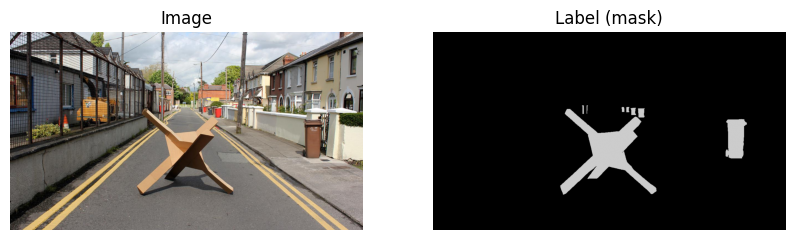

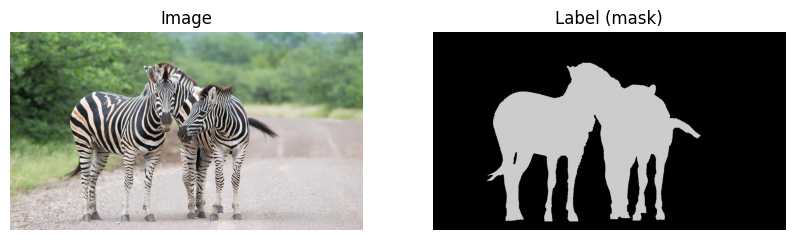

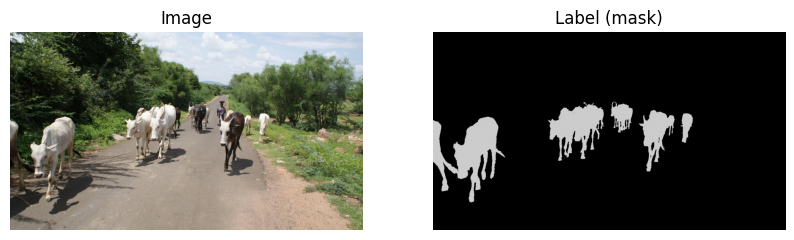

In [11]:
import matplotlib.pyplot as plt
import random
import numpy as np

# Pick how many samples to visualize
num_samples = 3

for _ in range(num_samples):
    idx = random.randint(0, len(dataset)-1)
    image, label = dataset[idx]

    # Convert image tensor to numpy for plotting
    if isinstance(image, torch.Tensor):
        # shape: [C, H, W] --> [H, W, C]
        img_np = image.permute(1, 2, 0).numpy()
    else:
        img_np = np.array(image)

    # Convert label tensor to numpy
    if isinstance(label, torch.Tensor):
        label_np = label.numpy()
    else:
        label_np = np.array(label)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(img_np)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Label (mask)")
    # Show label as grayscale if it's integer mask
    plt.imshow(label_np, cmap='nipy_spectral')  # 'tab20' or 'nipy_spectral' gives nice colors for classes
    plt.axis('off')

    plt.show()